In [20]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [21]:
train = pd.read_csv("data/train.csv", parse_dates=["date"])
test = pd.read_csv("data/test.csv", parse_dates=["date"])

holidays = pd.read_csv("data/holidays_events.csv", parse_dates=["date"]).rename(
    columns={"type": "holiday_type", "description": "holiday"}
)
oil = pd.read_csv("data/oil.csv", parse_dates=["date"])
trans = pd.read_csv("data/transactions.csv", parse_dates=["date"])
stores = pd.read_csv("data/stores.csv")


In [22]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [23]:
ALL_STORES = stores["store_nbr"].unique()
ALL_FAMILIES = train["family"].unique()

In [24]:
# append store info
# models will be per store/family, so really only need the city/state for holiday joins


def append_store_features(to, stores):
    sub = stores[["store_nbr", "city", "state"]]
    return to.merge(sub, on="store_nbr")


train_1 = append_store_features(train, stores)


## Holidays

In [25]:
def process_holidays(holidays):
    """clean holiday data according to the info given on kaggle"""

    h = holidays.copy()

    # fix transferred holidays. ones where transferred=True are regular days
    # day it was observed has holiday prefixed with "Traslado"
    # Primer dia del año 2017 is an exception, it's transferred but store is clearly closed that day
    h = h.query("not (transferred and holiday != 'Primer dia del ano')").copy()
    h["holiday"] = h.holiday.apply(lambda x: re.sub(r"^Traslado ", "", x))
    h.loc[h.date == "2017-01-02", "holiday"] = "Primer dia del ano+1"

    # fix bridges
    # 3 of the 5 bridge holidays have an "additional" holiday on the same day, keep the additional
    # "Work Day" types are added to make up for these that are not holidays, remove them
    h = h.query("not (holiday_type == 'Bridge' and date < '2015-01-01')")
    h = h.query("holiday_type != 'Work Day'")

    # split off events. want to keep dia de la madre/cyber monday/black friday as holidays
    # but give the mundials and the earthquake their owns dfs so they get their own one-off indicator
    mundial_inds = h[h.holiday.str.contains("Mundial")].index
    mundial_dates = set(h.loc[mundial_inds].date)
    h = h.drop(mundial_inds)

    earthquake_inds = h[h.holiday.str.contains("Terremoto")].index
    earthquake_dates = set(h.loc[earthquake_inds].date)
    h = h.drop(earthquake_inds)

    # handle one duplicate, a transfer/additional to the same day...
    h = h.query("not (date == '2016-07-24' and holiday == 'Fundacion de Guayaquil-1')")

    return h, mundial_dates, earthquake_dates


holidays_proc, mundial_dates, earthquake_dates = process_holidays(holidays)


In [26]:
def get_last_day_of_month(date):
    while True:
        date += pd.Timedelta(days=1)
        if date.day == 1:
            return date - pd.Timedelta(days=1)


def is_payday(date):
    """check if date is a payday, according to the info given on kaggle"""
    if date.day == 15:
        return True
    elif date.day < 28:
        return False
    else:
        return date == get_last_day_of_month(date)


def append_holiday_features(to, holidays, events):
    df = to.copy()

    # holidays: national, regional, local

    nat = holidays_proc.query("locale == 'National'").rename(
        columns={"holiday": "national_holiday"}
    )[["date", "national_holiday"]]
    reg = holidays_proc.query("locale == 'Regional'").rename(
        columns={"holiday": "regional_holiday"}
    )[["date", "locale_name", "regional_holiday"]]
    local = holidays_proc.query("locale == 'Local'").rename(
        columns={"holiday": "local_holiday"}
    )[["date", "locale_name", "local_holiday"]]

    assert nat.duplicated(subset="date").sum() == 0
    assert reg.duplicated(subset="date").sum() == 0
    assert local.duplicated(subset=["date", "locale_name"]).sum() == 0

    df = (
        df.merge(nat, on="date", how="left")
        .merge(
            reg, left_on=["date", "state"], right_on=["date", "locale_name"], how="left"
        )
        .drop("locale_name", axis=1)
        .merge(
            local,
            left_on=["date", "city"],
            right_on=["date", "locale_name"],
            how="left",
        )
        .drop("locale_name", axis=1)
    )

    # events

    for key, dates in events.items():
        df[key] = df.date.isin(dates).astype(int)

    # paydays

    df["is_payday"] = df.date.apply(is_payday).astype(int)

    return df


train_2 = append_holiday_features(
    train_1, holidays_proc, {"earthquake": earthquake_dates, "mundials": mundial_dates}
)


In [27]:
def append_time_features(to):
    df = to.copy()

    date_map = {date: i for i, date in enumerate(sorted(df.date.unique()))}
    df["trend"] = df.date.map(date_map)

    df["year"] = df.date.dt.year
    df["quarter"] = df.date.dt.quarter
    df["month"] = df.date.dt.month
    df["weekday"] = df.date.dt.weekday
    df["year"] = df.date.dt.year
    df["is_weekend"] = df.weekday.isin([5, 6]).astype(int)

    return df


train_3 = append_time_features(train_2)


In [28]:
def append_lag_sales(to):
    df = to.copy()

    day_mean = df.groupby("trend").sales.mean()
    store_mean = df.groupby("store_nbr").sales.mean()
    family_mean = df.groupby("family").sales.mean()

    days = [16, 18, 20, 21, 25, 28, 30, 31, 35, 42, 60, 90, 120, 180, 365]
    for day in days:
        df[f"sales_lag_{day}"] = df.trend.map(day_mean.shift(day)).fillna(0)

    df["store_mean"] = df.store_nbr.map(store_mean)
    df["family_mean"] = df.family.map(family_mean)

    return df


train_4 = append_lag_sales(train_3)


In [29]:
CATS = [
    "national_holiday",
    "regional_holiday",
    "local_holiday",
    "year",
    "quarter",
    "month",
    "weekday",
]


def encode_categorical(to):
    df = to.copy()
    df = pd.get_dummies(df, columns=CATS)
    return df


train_5 = encode_categorical(train_4)


In [53]:
DROP = [
    "id",
    "date",
    "store_nbr",
    "family",
    "city",
    "state",
]

VAL_PERIODS = 16
ZERO_FORECAST_THRESH = 16

val_preds = {}

params = {
    "criterion": "squared_error",
    "bootstrap": "False",
    "max_depth": 9733,
    "max_features": 1.0,
    "max_leaf_nodes": 4730,
    "n_estimators": 159,
    "min_samples_split": 3,
    "min_samples_leaf": 8,
}

for store in ALL_STORES:
    for family in ALL_FAMILIES:
        sub = train_5.query("date >= '2016-01-01' and store_nbr == @store and family == @family").drop(DROP, axis=1)
        _train, _val = sub[:-VAL_PERIODS], sub[-VAL_PERIODS:]

        X_train = _train.drop("sales", axis=1)
        X_val = _val.drop("sales", axis=1)
        y_train = _train.sales
        y_val = _val.sales

        if (y_train[-ZERO_FORECAST_THRESH:] == 0).all():
            print(f"zero forecast for {store} {family}")
            preds = np.zeros(VAL_PERIODS)
        
        else:
            clf = RandomForestRegressor(**params)
            clf.fit(X_train, y_train)
            preds = clf.predict(X_val)
            
        print(f"store {store}, family {family}: {mean_squared_log_error(y_val, preds, squared=False)}")

        val_preds.update({index: pred for index, pred in zip(_val.index, preds)})



store 1, family AUTOMOTIVE: 0.5796990760885302
zero forecast for 1 BABY CARE
store 1, family BABY CARE: 0.0
store 1, family BEAUTY: 0.42310023014003195
store 1, family BEVERAGES: 0.24659971852931198
store 1, family BOOKS: 0.30915715558686696
store 1, family BREAD/BAKERY: 0.31173786896408295
store 1, family CELEBRATION: 0.8436807980807284
store 1, family CLEANING: 0.31272353031490935
store 1, family DAIRY: 0.26607216850126414
store 1, family DELI: 0.23831047830032445
store 1, family EGGS: 0.24426204708611424
store 1, family FROZEN FOODS: 0.28871761754997494
store 1, family GROCERY I: 0.2672590279330546
store 1, family GROCERY II: 0.5127965865316306
store 1, family HARDWARE: 0.6138839710940381
store 1, family HOME AND KITCHEN I: 0.5289819507049622
store 1, family HOME AND KITCHEN II: 0.2738901063588394
store 1, family HOME APPLIANCES: 0.4508189271070569
store 1, family HOME CARE: 0.3089870042357417
store 1, family LADIESWEAR: 0.44085131360743585
store 1, family LAWN AND GARDEN: 0.3817462

In [54]:
pred_df = train_5.loc[val_preds.keys()]["sales"].to_frame()
pred_df["preds"] = pred_df.index.map(val_preds)

print(f"validation RMSLE: {mean_squared_log_error(pred_df.sales, pred_df.preds, squared=False)}")

validation RMSLE: 0.43301815849289893


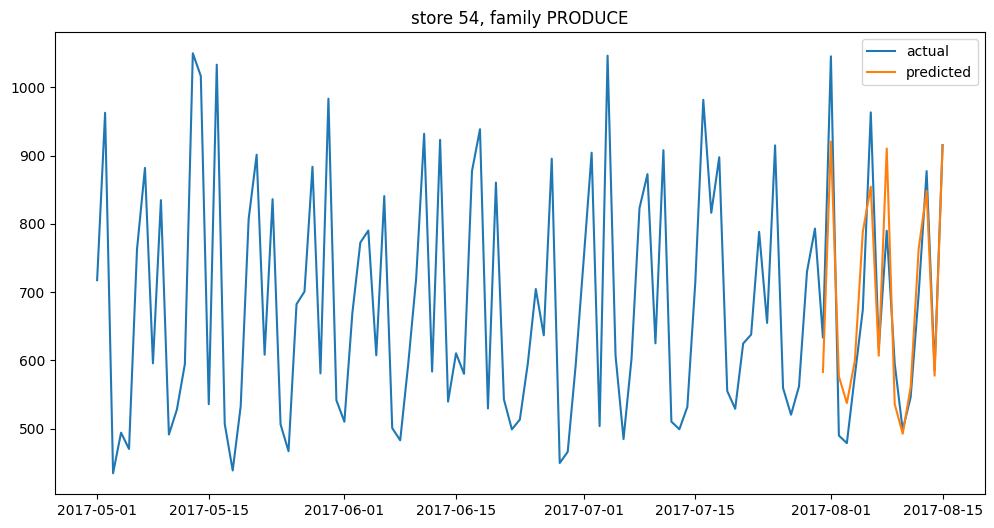

In [58]:
# show an example store/family pred

def show_example_plot(store, family):
    ex = train_5.query("date >= '2017-05-01' and store_nbr == @store and family == @family").copy()
    ex["preds"] = ex.index.map(val_preds)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(ex.date, ex.sales, label="actual")
    ax.plot(ex.date, ex.preds, label="predicted")
    ax.legend()
    ax.set_title(f"store {store}, family {family}")
    plt.show()

show_example_plot(54, "PRODUCE")


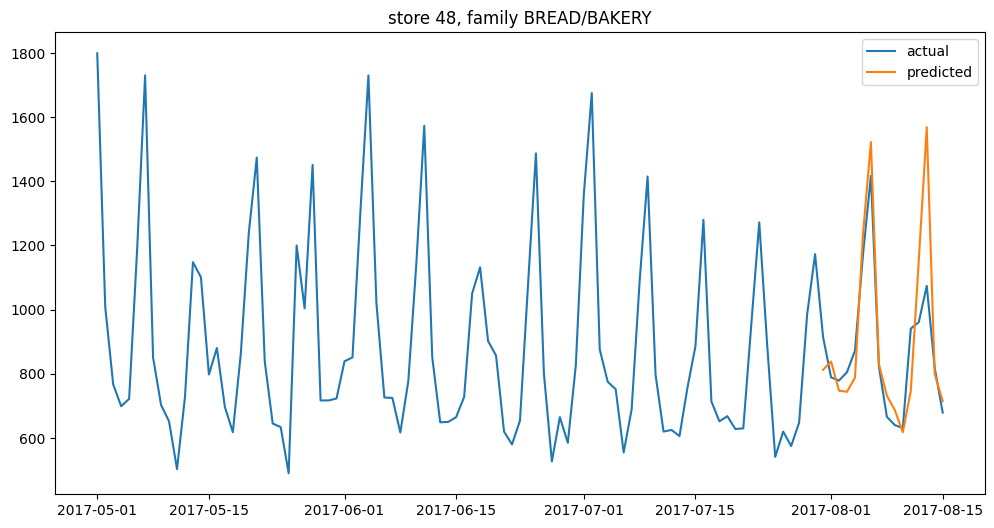

In [61]:
show_example_plot(48, "BREAD/BAKERY")

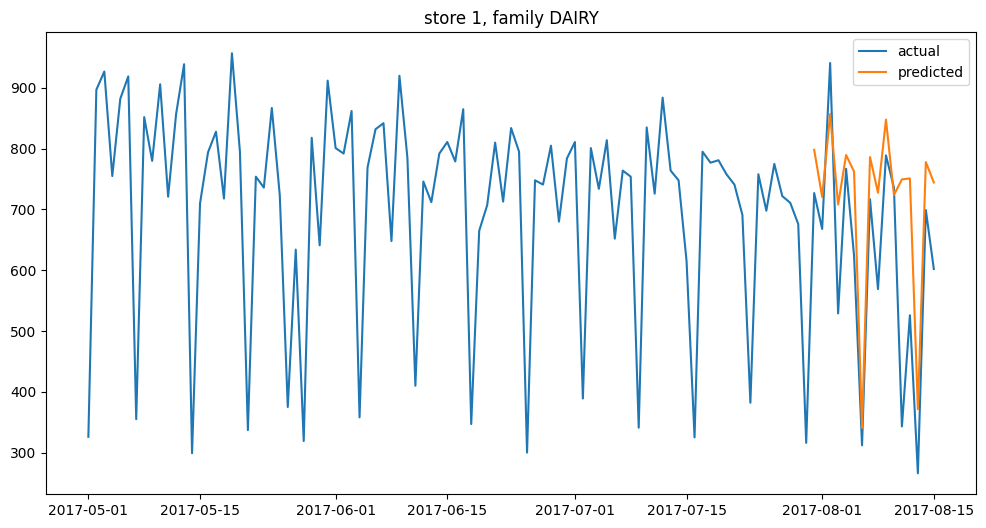

In [63]:
show_example_plot(1, "DAIRY")